In [1]:
import json
import pandas as pd

# TODO download data from the website
rows = []
filename = 'sample_data/News_Category_Dataset_v2.json'
with open(filename) as f:
    for line in f:
        rows.append(json.loads(line))

data = pd.DataFrame(rows)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200853 entries, 0 to 200852
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype   
---  ------    --------------   -----   
 0   category  200853 non-null  category
 1   headline  200853 non-null  object  
dtypes: category(1), object(1)
memory usage: 1.7+ MB
None


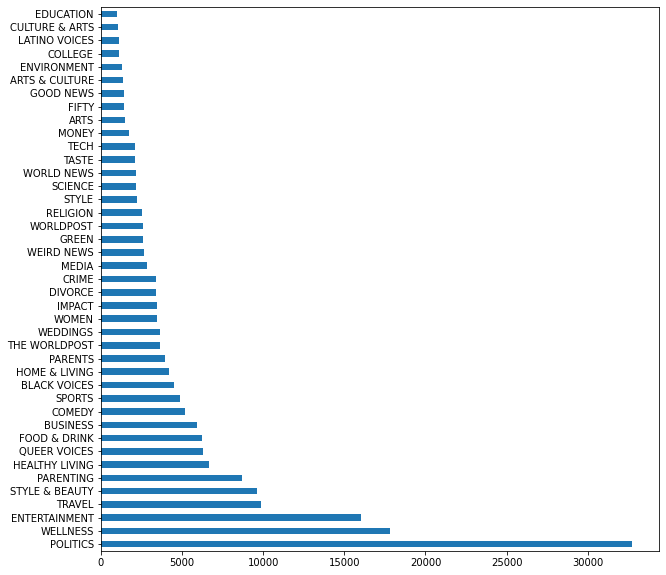

In [2]:
data = data.drop(columns=['authors', 'link', 'short_description', 'date'])
data['category'] = data['category'].astype('category')

data['category'].value_counts().plot.barh(figsize=(10,10))
print(data.info())

In [3]:
# Merge similar categories

new_categories = {
    'ENVIRONMENT': ['GREEN', 'ENVIRONMENT'],
    'GROUPS VOICES': ['LATINO VOICES', 'BLACK VOICES', 'QUEER VOICES'],
    'CULTURE': ['CULTURE & ARTS', 'ARTS & CULTURE', 'ARTS', 'RELIGION'],
    'FINANCE': ['BUSINESS', 'MONEY'],
    'SCIENCE & TECH': ['SCIENCE', 'TECH'],
    'EDUCATION': ['EDUCATION', 'COLLEGE'],
    'WORLD NEWS': ['WORLD NEWS', 'THE WORLDPOST' , 'WORLDPOST'],
    'ENTERTAINMENT': ['ENTERTAINMENT', 'COMEDY'],
    'WELLNESS': ['HEALTHY LIVING', 'WELLNESS'],
    'FOOD & DRINK': ['FOOD & DRINK', 'TASTE'],
    'STYLE & BEAUTY': ['STYLE & BEAUTY', 'STYLE'],
    'RELATIONSHIPS': ['PARENTING', 'PARENTS', 'WEDDINGS', 'DIVORCE'],
    'OTHER': ['GOOD NEWS', 'WEIRD NEWS', 'FIFTY']
}

mapper = {}
for key, values in new_categories.items():
    for val in values:
        mapper[val] = key

data_org = data
data = data.replace({'category': mapper})

Number of all headlines 200853.


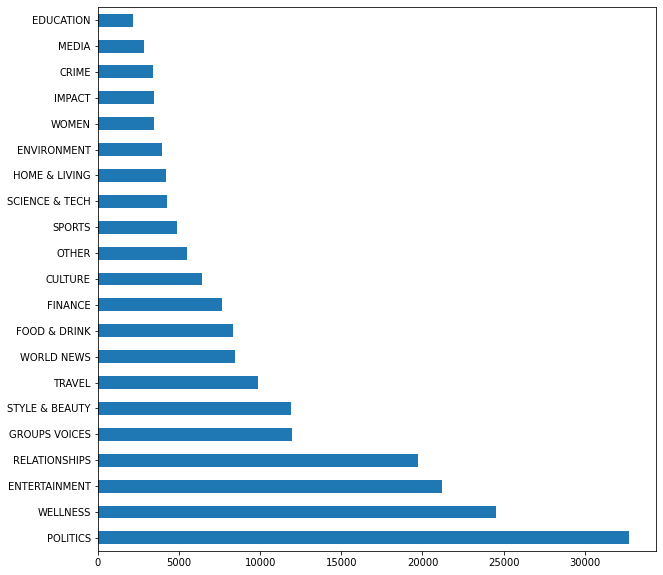

In [4]:
data['category'].value_counts().plot.barh(figsize=(10,10))
print("Number of all headlines %d." % len(data))

In [5]:
import nltk
import re
import numpy as np

nltk.download('stopwords')
from nltk.corpus import stopwords

def preprocess(text):
    text = re.sub("U.S.", "USA", text)
    text = re.sub("[^a-z ]", " ", text.lower())
    text = re.sub("photos?|videos?", "", text)
    words = text.split()
    words = [w for w in words if w not in stopwords.words("english")]
    return words

data['headline'] = data['headline'].apply(preprocess)
print(data)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
              category                                           headline
0                CRIME           [mass, shootings, texas, last, week, tv]
1        ENTERTAINMENT  [smith, joins, diplo, nicky, jam, world, cup, ...
2        ENTERTAINMENT           [hugh, grant, marries, first, time, age]
3        ENTERTAINMENT  [jim, carrey, blasts, castrato, adam, schiff, ...
4        ENTERTAINMENT  [julianna, margulies, uses, donald, trump, poo...
...                ...                                                ...
200848  SCIENCE & TECH  [rim, ceo, thorsten, heins, significant, plans...
200849          SPORTS  [maria, sharapova, stunned, victoria, azarenka...
200850          SPORTS  [giants, patriots, jets, colts, among, improba...
200851          SPORTS  [aldon, smith, arrested, ers, linebacker, bust...
200852          SPORTS  [dwight, howard, rips, teammates, magic, lo

In [7]:
from collections import Counter
from pandas.core.common import flatten

grouped = data.groupby(by='category', as_index=False).agg(lambda a: list(flatten(a)))
grouped['headline'] = [Counter(h_a) for h_a in  grouped['headline']]
grouped['common_words'] = [sorted(group.items(), key=lambda x: x[1], reverse=True)[:10] for group in grouped['headline']]

for _, row in grouped.iterrows():
    print(row['category'], row['common_words'])

CRIME [('police', 456), ('man', 421), ('shooting', 260), ('cops', 186), ('year', 178), ('killed', 173), ('suspect', 168), ('woman', 164), ('dead', 160), ('old', 159)]
CULTURE [('art', 446), ('new', 281), ('pope', 271), ('artist', 225), ('world', 181), ('trump', 166), ('francis', 160), ('women', 157), ('church', 134), ('meditation', 134)]
EDUCATION [('college', 289), ('education', 179), ('students', 167), ('school', 166), ('student', 120), ('university', 103), ('schools', 80), ('new', 75), ('campus', 75), ('sexual', 73)]
ENTERTAINMENT [('trump', 1742), ('new', 1286), ('donald', 943), ('star', 609), ('show', 588), ('says', 555), ('first', 541), ('snl', 529), ('movie', 461), ('jimmy', 442)]
ENVIRONMENT [('climate', 475), ('change', 274), ('week', 174), ('new', 159), ('animal', 146), ('dog', 143), ('california', 134), ('world', 109), ('usa', 108), ('oil', 108)]
FINANCE [('business', 406), ('women', 313), ('new', 263), ('wall', 239), ('tax', 205), ('money', 200), ('america', 188), ('ceo', 1

In [8]:
# Bag of words - take n most common words from each category
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfTransformer

def dummy(vec):
    return vec

# TODO what about HashingVectorizer
# TODO add tokenizer and preprocessor here
vectorizer = CountVectorizer(tokenizer=dummy, preprocessor=dummy)
X = vectorizer.fit_transform(data['headline'])
print("Number of tokens:", len(vectorizer.get_feature_names()))

print("Shape of X:", X.shape)

X_train, X_test, y_train, y_test = train_test_split(X, data['category'], train_size=0.7)


Number of tokens: 54440
Shape of X: (200853, 54440)


In [9]:
from sklearn import metrics
from time import time

def test_classifier(clf):
    train_t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - train_t0

    pred_t0 = time()
    pred = clf.predict(X_test)
    pred_time = time() - pred_t0

    acc = metrics.accuracy_score(y_test, pred)
    prec = metrics.precision_score(y_test, pred, average='weighted')
    rec = metrics.recall_score(y_test, pred, average='weighted')
    f1 = metrics.f1_score(y_test, pred, average='weighted')

    print(clf.__class__.__name__)
    print("SCORES Accuracy: %.3f. Precision: %.3f. Recall: %.3f. F1: %.3f." % (acc, prec, rec ,f1))
    print("TRAINING TIME %.3f s." % train_time)
    print("PREDICTION TIME %.3f s." % pred_time)
    print("-------------------------------")

    return pred

def binary_class_precision(y_test, pred, labels, print_scores=False):
    precision = {}
    for label in labels:
        bin_y_test = y_test == label
        bin_pred = pred == label
        precision[label] = metrics.precision_score(bin_y_test, bin_pred)
        if print_scores:
            print(label, precision[label])
    return precision

In [10]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier

clf = LinearSVC()
pred = test_classifier(clf)

labels = data['category'].value_counts().keys()
binary_class_precision(y_test, pred, labels, print_scores=True)
print("-------------------------------")

clf = SGDClassifier(alpha=.0001, max_iter=50, penalty="elasticnet")
test_classifier(clf)

clf = BernoulliNB()
test_classifier(clf)

# clf = RandomForestClassifier()
# test_classifier(clf)

LinearSVC
SCORES Accuracy: 0.635. Precision: 0.629. Recall: 0.635. F1: 0.630.
TRAINING TIME 43.679 s.
PREDICTION TIME 0.028 s.
-------------------------------
POLITICS 0.7302388813361818
WELLNESS 0.6178365547643269
ENTERTAINMENT 0.6746096959737058
RELATIONSHIPS 0.6638893255777394
GROUPS VOICES 0.6128332300061996
STYLE & BEAUTY 0.7560414269275029
TRAVEL 0.6902510596674275
WORLD NEWS 0.6511721907841552
FOOD & DRINK 0.7263931888544891
FINANCE 0.49886415265788275
CULTURE 0.49879227053140096
OTHER 0.33252032520325203
SPORTS 0.6668984700973575
SCIENCE & TECH 0.4750219106047327
HOME & LIVING 0.6726973684210527
ENVIRONMENT 0.44465116279069766
WOMEN 0.34124293785310733
IMPACT 0.3147410358565737
CRIME 0.5392781316348195
MEDIA 0.4884353741496599
EDUCATION 0.4010600706713781
-------------------------------
SGDClassifier
SCORES Accuracy: 0.615. Precision: 0.605. Recall: 0.615. F1: 0.600.
TRAINING TIME 7.676 s.
PREDICTION TIME 0.032 s.
-------------------------------


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


BernoulliNB
SCORES Accuracy: 0.529. Precision: 0.616. Recall: 0.529. F1: 0.461.
TRAINING TIME 0.661 s.
PREDICTION TIME 0.088 s.
-------------------------------


array(['POLITICS', 'WELLNESS', 'POLITICS', ..., 'RELATIONSHIPS', 'TRAVEL',
       'POLITICS'], dtype='<U14')

In [ ]:
from sklearn.decomposition import TruncatedSVD 
import seaborn as sns

pca = TruncatedSVD(n_components=2)
X_pca = pca.fit(X)
X_pca_scores = X_pca.transform(X)
data['category'] = data['category'].astype('category')

plt.figure(figsize=(10, 10))
sns.scatterplot(x=X_pca_scores[:, 0], y=X_pca_scores[:, 1], hue=data['category'].cat.codes)


In [ ]:
# Only important tokens:

# 1) use the vocabulary feature in CountVectorized: a dict, where keys are 
#    terms and values are indices in the feature matrix, or an iterable over
#    terms
# 2) use max_features/min_df/max_df in CountVectorized
# 3) use TfidfTransformer